# Project : Customer Purchase Behavior Analysis Using PySpark.
### Problem Statement:
Retail companies collect vast amounts of transaction data but struggle to derive meaningful insights from it. This project aims to analyze a large retail dataset using PySpark to understand customer purchase behavior, identify high-value customers, and optimize inventory and sales strategies.

Setting up the Enviroment

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings("ignore")


Make spark Session

In [2]:
spark = SparkSession.builder.appName('myApp').getOrCreate()

In [3]:
df = spark.read.csv('C:\PySpark Learnings\Online Retail.csv', header=True, inferSchema=True)
df.show()

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|    22752|SET 7 BABUSHKA NE...|       2|12/1/2010 8:26|     7.65|     17850|United Kingdom|
|   536365|    21730|GLASS STAR FROSTE...|       6|12/1/2010 8:26|     4.

In [4]:
df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [5]:
# Type Casting
df = df.withColumn("InvoiceDate", to_timestamp(col("InvoiceDate"), "M/d/yyyy H:mm"))
df.show(5)


+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
only showing top 5 rows



In [6]:
# checking the proper schema and data
df.printSchema()
df.show(5)

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|     17850|United Kingdom|
|   536365|

In [7]:
from pyspark.sql.functions import count, when

df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|        0|        0|       1454|       0|          0|        0|    135080|      0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



As our main focus is on customer behaviour we are going to drop the rows with null values.
we dont require Description columns for any analysis or computetion we store it as it is.

In [8]:
df = df.na.drop(subset=['CustomerID'])
df = df.na.drop(subset=['Description'])

In [9]:
# removing the negative values in quantity column
df = df.filter(col("Quantity")>0)

In [10]:
df = df.withColumn("UnitPrice", when(col("UnitPrice") < 0, abs(col("UnitPrice"))).otherwise(col("UnitPrice")))

# Exploratory data analysis

In [11]:
df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [12]:
df.describe().show()

+-------+------------------+------------------+--------------------+------------------+-----------------+------------------+-----------+
|summary|         InvoiceNo|         StockCode|         Description|          Quantity|        UnitPrice|        CustomerID|    Country|
+-------+------------------+------------------+--------------------+------------------+-----------------+------------------+-----------+
|  count|            397924|            397924|              397924|            397924|           397924|            397924|     397924|
|   mean| 560617.1266447864| 27420.22580442879|                NULL|13.021823262733587|3.116174480555487|15294.315170736121|       NULL|
| stddev|13106.167694745218|16390.678394746366|                NULL|180.42020991698146|22.09678803168579| 1713.169877338219|       NULL|
|    min|            536365|             10002| 4 PURPLE FLOCK D...|                 1|              0.0|             12346|  Australia|
|    max|            581587|             

Explore the Total revenue per product

In [13]:
df.groupBy("Description").agg(sum('UnitPrice').alias('TotalSales')).orderBy("TotalSales", ascending=False).show()

+--------------------+------------------+
|         Description|        TotalSales|
+--------------------+------------------+
|              Manual|          49782.81|
|             POSTAGE|          34695.96|
|REGENCY CAKESTAND...| 21508.89999999997|
|      DOTCOM POSTAGE|          11906.36|
|       PARTY BUNTING| 6807.419999999979|
|            CARRIAGE|            6668.0|
|WHITE HANGING HEA...| 5867.220000000036|
|CREAM SWEETHEART ...| 5755.060000000001|
|SET OF 3 CAKE TIN...| 5741.240000000016|
|BREAD BIN DINER S...| 5636.030000000008|
|VINTAGE RED KITCH...|            5450.0|
|IVORY KITCHEN SCALES|5449.9000000000015|
|DOORMAT KEEP CALM...| 5183.350000000001|
|      SPOTTY BUNTING|5001.5399999999945|
|LOVE SEAT ANTIQUE...|            4675.0|
|RED RETROSPOT CAK...| 4594.950000000009|
|WOOD BLACK BOARD ...|4523.2700000000095|
|DOORMAT RED RETRO...| 4492.920000000008|
|BAKING SET 9 PIEC...| 4325.240000000016|
|HOME BUILDING BLO...| 4272.760000000012|
+--------------------+------------

Exploring Total Quantity sold per prodect

In [14]:
df.groupBy("Description").agg(sum('Quantity').alias('QuntitySold')).orderBy("QuntitySold", ascending=False).show()

+--------------------+-----------+
|         Description|QuntitySold|
+--------------------+-----------+
|PAPER CRAFT , LIT...|      80995|
|MEDIUM CERAMIC TO...|      77916|
|WORLD WAR 2 GLIDE...|      54415|
|JUMBO BAG RED RET...|      46181|
|WHITE HANGING HEA...|      36725|
|ASSORTED COLOUR B...|      35362|
|PACK OF 72 RETROS...|      33693|
|      POPCORN HOLDER|      30931|
|  RABBIT NIGHT LIGHT|      27202|
|MINI PAINT SET VI...|      26076|
|PACK OF 12 LONDON...|      25345|
|PACK OF 60 PINK P...|      24264|
| BROCADE RING PURSE |      22963|
|VICTORIAN GLASS H...|      22433|
|ASSORTED COLOURS ...|      21876|
|RED  HARMONICA IN...|      20975|
|JUMBO BAG PINK PO...|      20165|
|SMALL POPCORN HOLDER|      18252|
|LUNCH BAG RED RET...|      17697|
|60 TEATIME FAIRY ...|      17689|
+--------------------+-----------+
only showing top 20 rows



Creating column to understand Total Amount Spend

In [15]:
df = df.withColumn("TotalAmount", 
            round(col('Quantity')*col("UnitPrice"),2)
            )

In [16]:
df.show()

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+-----------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|TotalAmount|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+-----------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|     17850|United Kingdom|       15.3|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|     17850|United Kingdom|      20.34|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|     17850|United Kingdom|       22.0|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|     17850|United Kingdom|      20.34|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|     17850|United Kingdom|      20.34|
|   536365|    22752|SET 7 BABUSHKA NE..

Identiy the top customers (Revenue Generators)

In [17]:
df_top_customers = df.groupby("CustomerID").sum('TotalAmount')

df_top_customers = df.withColumnRenamed("sum('TotalAmount')", "TotalAmountSum")

df_top_customers.orderBy(col("TotalAmount").desc()).show(5,False)

+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+-----------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |TotalAmount|
+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+-----------+
|581483   |23843    |PAPER CRAFT , LITTLE BIRDIE        |80995   |2011-12-09 09:15:00|2.08     |16446     |United Kingdom|168469.6   |
|541431   |23166    |MEDIUM CERAMIC TOP STORAGE JAR     |74215   |2011-01-18 10:01:00|1.04     |12346     |United Kingdom|77183.6    |
|556444   |22502    |PICNIC BASKET WICKER 60 PIECES     |60      |2011-06-10 15:28:00|649.5    |15098     |United Kingdom|38970.0    |
|551697   |POST     |POSTAGE                            |1       |2011-05-03 13:46:00|8142.75  |16029     |United Kingdom|8142.75    |
|567423   |23243    |SET OF TEA COFFEE SUGAR TINS PANTR

# RFM Analysis (Recency, Frequency, Monetary)

In [18]:
# latest purchase data in dataset
max_date = df.agg(max("InvoiceDate")).collect()[0][0]

# Compute RFM Matrics

rfm_df = df.groupBy("CustomerID").agg(
    date_diff(lit(max_date), max(col('InvoiceDate'))).alias("Recency"),
    count("InvoiceNo").alias("Frequency"),
    sum("TotalAmount").alias('Monetary')
).orderBy(col("Frequency").desc())

In [19]:
rfm_df = rfm_df.withColumn(
    "R_Score", when(col("Recency") <= 30, 3).when(col("Recency") <= 90, 2).otherwise(1)
)
rfm_df = rfm_df.withColumn(
    "F_Score", when(col("Frequency") > 50, 3).when(col("Frequency") > 20, 2).otherwise(1)
)
rfm_df = rfm_df.withColumn(
    "M_Score", when(col("Monetary") > 1000, 3).when(col("Monetary") > 500, 2).otherwise(1)
)

# Final segment assignment
rfm_df = rfm_df.withColumn(
    "Segment",
    when((col("R_Score") + col("F_Score") + col("M_Score")) >= 8, "High Value")
    .when((col("R_Score") + col("F_Score") + col("M_Score")) >= 5, "Medium Value")
    .otherwise("Low Value")
)

rfm_df

DataFrame[CustomerID: int, Recency: int, Frequency: bigint, Monetary: double, R_Score: int, F_Score: int, M_Score: int, Segment: string]

# Churn Analysis
Identifying the customer whe purchase only ones

In [20]:
one_time_buyers = df.groupBy('CustomerID').count().filter("count = 1")
one_time_buyers.show()

+----------+-----+
|CustomerID|count|
+----------+-----+
|     15070|    1|
|     16738|    1|
|     18113|    1|
|     16078|    1|
|     15940|    1|
|     16148|    1|
|     16073|    1|
|     18068|    1|
|     15562|    1|
|     12346|    1|
|     15753|    1|
|     15823|    1|
|     13703|    1|
|     17291|    1|
|     16765|    1|
|     17752|    1|
|     17923|    1|
|     17763|    1|
|     17925|    1|
|     13185|    1|
+----------+-----+
only showing top 20 rows



Indentify churned customers (Long Inactivity)

In [21]:
max_date = df.agg(max('InvoiceDate')).collect()[0][0]

last_purchase_date = df.groupBy('CustomerID').agg(max('InvoiceDate').alias("last_puchase_date"))

last_purchase_date = last_purchase_date.withColumn("DaysSinceLastPurchase",
                                                   date_diff(lit(max_date),col("last_puchase_date"))
                                                )

churned_customers = last_purchase_date.filter(col("DaysSinceLastPurchase") > 180)
churned_customers.show()



+----------+-------------------+---------------------+
|CustomerID|  last_puchase_date|DaysSinceLastPurchase|
+----------+-------------------+---------------------+
|     15447|2011-01-13 11:26:00|                  330|
|     16339|2011-02-28 13:41:00|                  284|
|     14570|2011-03-04 10:58:00|                  280|
|     15100|2011-01-10 10:35:00|                  333|
|     14465|2011-04-07 12:38:00|                  246|
|     13261|2011-03-16 12:22:00|                  268|
|     18218|2011-05-12 12:53:00|                  211|
|     14536|2011-03-25 12:21:00|                  259|
|     17708|2011-06-05 10:12:00|                  187|
|     14377|2011-06-01 13:32:00|                  191|
|     17775|2011-03-30 10:50:00|                  254|
|     13060|2011-03-31 11:37:00|                  253|
|     17223|2011-02-02 15:57:00|                  310|
|     13898|2011-01-18 10:28:00|                  325|
|     16565|2010-12-10 15:21:00|                  364|
|     1477

Calculate Customer Churn rate

In [22]:
# total customers
total_customers = df.select("CustomerID").distinct().count()
# churn customers
churn_count = churned_customers.count()

churn_rate = (churn_count/total_customers)*100
print(f"Customer Churn Rate : {churn_rate:.2f}%")

Customer Churn Rate : 19.77%


Analyze Repeat purchase behaviour

In [23]:
repeat_cust = df.groupby("CustomerID").count().filter("count > 1")
repeat_cust.show()

+----------+-----+
|CustomerID|count|
+----------+-----+
|     17420|   30|
|     16503|   84|
|     15727|  302|
|     17389|  213|
|     15447|    9|
|     14450|   40|
|     13623|   81|
|     13285|  187|
|     16339|   20|
|     14570|   29|
|     16386|   88|
|     15100|    3|
|     16916|  143|
|     12471|  460|
|     14514|   73|
|     16500|   11|
|     12626|  294|
|     18161|   80|
|     15967|   84|
|     14465|  130|
+----------+-----+
only showing top 20 rows



# Answering Business Question for Different areas

### Customer Insights

The top 10 most valuable customers based on total spending

In [24]:
df_top_customers = df.groupby("CustomerID").sum('TotalAmount')

df_top_customers = df.withColumnRenamed("sum('TotalAmount')", "TotalAmountSum")

df_top_customers = df_top_customers.orderBy(col("TotalAmount").desc()).limit(15)

In [25]:
top_ten_customers = df_top_customers.toPandas()
top_ten_customers

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom,168469.60
1,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,77183.60
2,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098,United Kingdom,38970.00
3,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029,United Kingdom,8142.75
4,567423,23243,SET OF TEA COFFEE SUGAR TINS PANTRY,1412,2011-09-20 11:05:00,5.06,17450,United Kingdom,7144.72
5,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-01-11 12:55:00,2.10,15749,United Kingdom,6539.40
6,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-04-18 13:20:00,2.10,15749,United Kingdom,6539.40
7,573003,23084,RABBIT NIGHT LIGHT,2400,2011-10-27 12:11:00,2.08,14646,Netherlands,4992.00
8,540815,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1930,2011-01-11 12:55:00,2.55,15749,United Kingdom,4921.50
9,550461,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1930,2011-04-18 13:20:00,2.40,15749,United Kingdom,4632.00


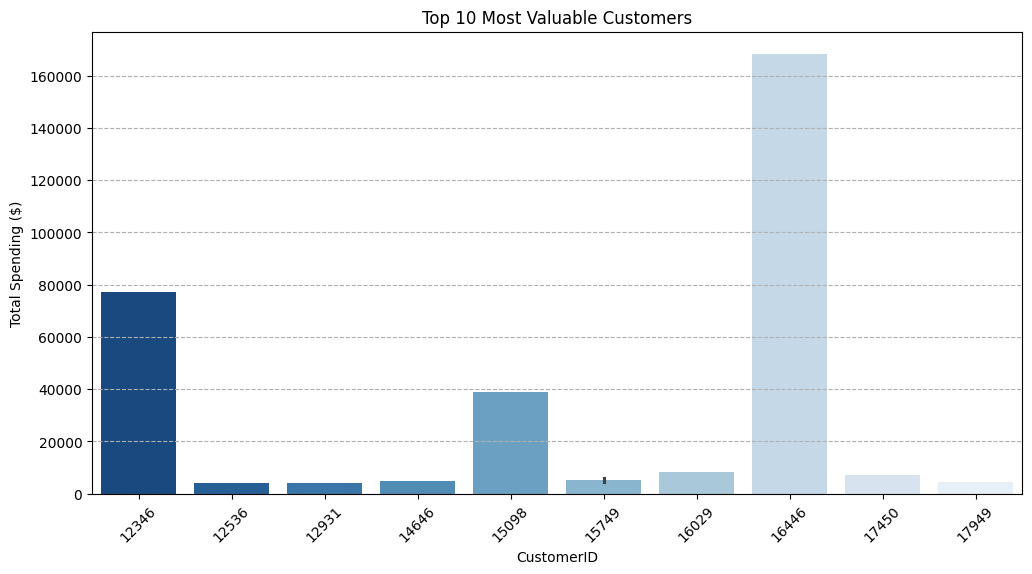

In [26]:
plt.figure(figsize=(12,6))
sns.barplot(data=top_ten_customers, x="CustomerID", y="TotalAmount", palette="Blues_r")
plt.ylabel("Total Spending ($)")
plt.title("Top 10 Most Valuable Customers")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--")
plt.show()

Top 10 Most frequent Customers with Monetary

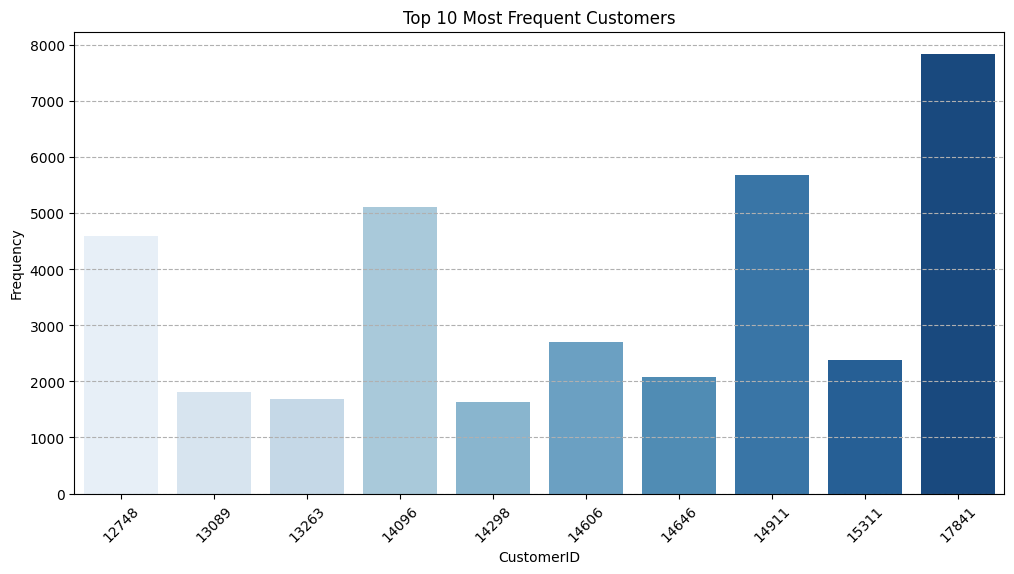

In [27]:
top_ten_frm = rfm_df.orderBy(col("frequency").desc()).limit(10)
top_cust_pd = top_ten_frm.toPandas()
plt.figure(figsize=(12,6))
sns.barplot(data=top_cust_pd, x="CustomerID", y="Frequency", palette="Blues")
plt.ylabel("Frequency")
plt.title("Top 10 Most Frequent Customers")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--")
plt.show()



Average Order Value per Customer

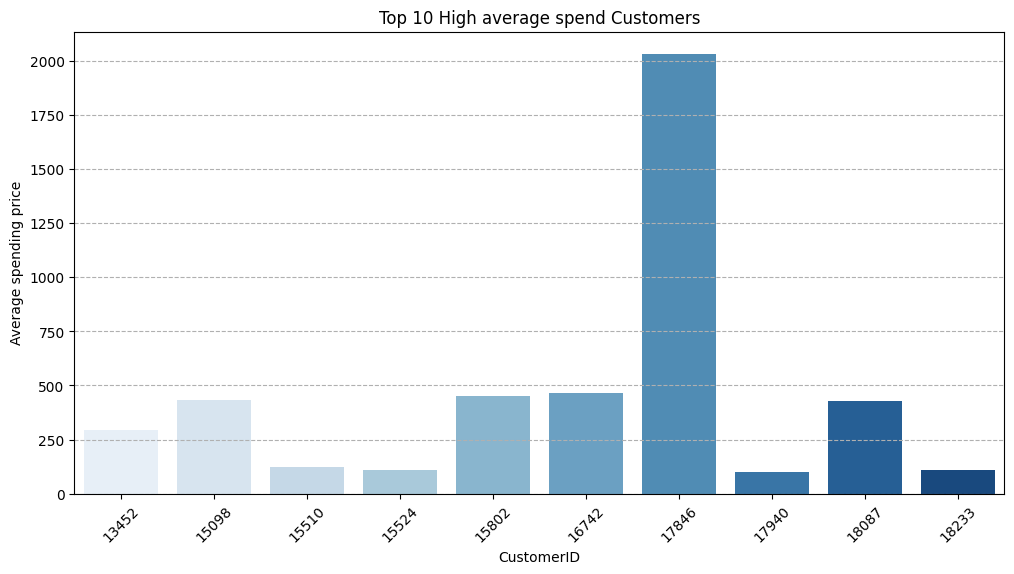

In [28]:
avg_order_value = df.groupBy("CustomerID").agg(
    avg(col("UnitPrice")).alias("avg_price")).orderBy(col("avg_price").desc()).limit(10)

top_high_avg_price_cust = avg_order_value.toPandas()
plt.figure(figsize=(12,6))
sns.barplot(data=top_high_avg_price_cust, x="CustomerID", y="avg_price", palette="Blues")
plt.ylabel("Average spending price")
plt.title("Top 10 High average spend Customers")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--")
plt.show()


Analyze most and Least Selling Products

In [29]:
most_selling_product = df.groupBy("StockCode","Description").agg(sum('Quantity').alias('TotalQuantity')).orderBy(col("TotalQuantity").desc()).limit(10)
least_selling_product = df.groupBy("StockCode","Description").agg(sum('Quantity').alias('TotalQuantity')).orderBy(col("TotalQuantity").asc()).limit(10)


In [30]:
most_selling_product_df = most_selling_product.toPandas()
least_selling_product_df = least_selling_product.toPandas()


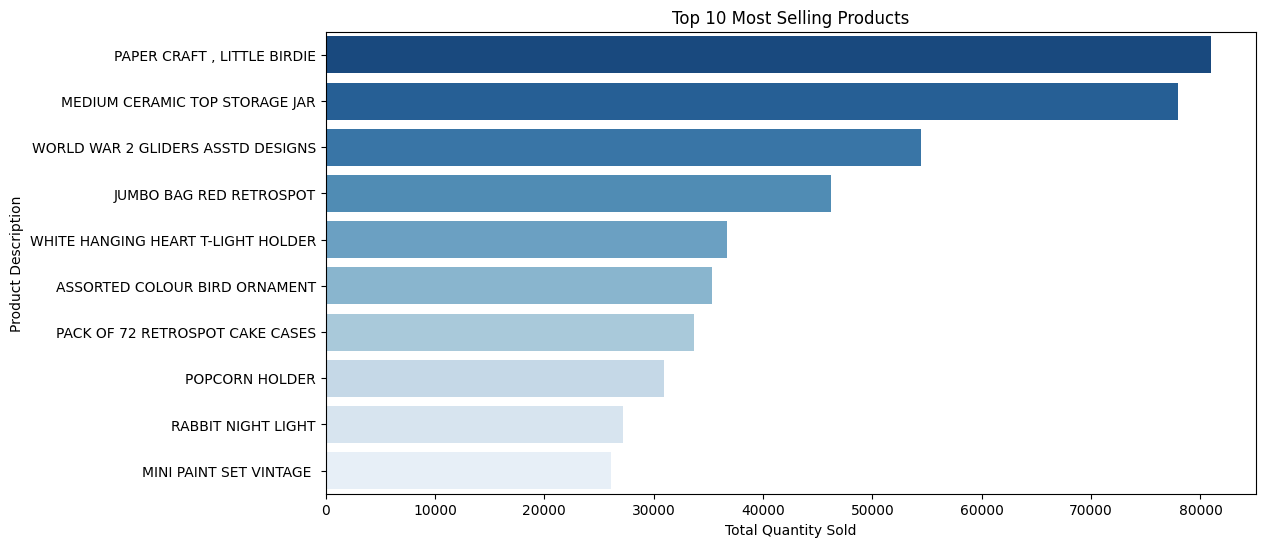

In [31]:

top_selling_products = most_selling_product_df.head(10)
plt.figure(figsize=(12, 6))
sns.barplot(data=most_selling_product_df, x="TotalQuantity", y="Description", palette="Blues_r")
plt.xlabel("Total Quantity Sold")
plt.ylabel("Product Description")
plt.title("Top 10 Most Selling Products")
plt.show()


Most Selling Product

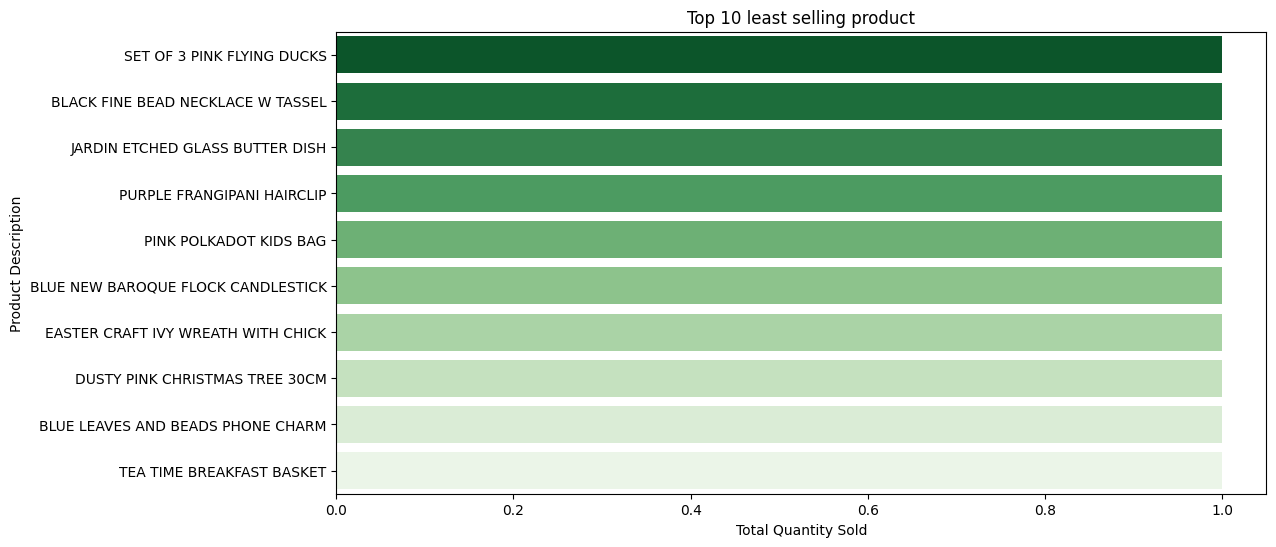

In [32]:
plt.figure(figsize=(12,6))
sns.barplot(data=least_selling_product_df,x="TotalQuantity",y="Description", palette="Greens_r")
plt.title("Top 10 least selling product")
plt.xlabel("Total Quantity Sold")
plt.ylabel("Product Description")
plt.show()

# Sales Trend Analysis

How do sales vary across different months?

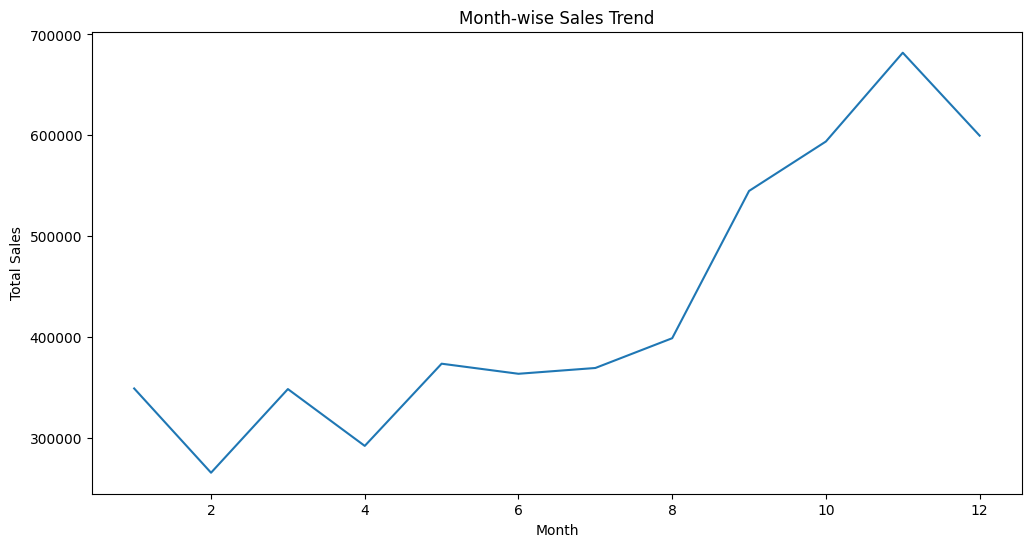

In [33]:
sales_by_month = df.groupBy(month(col("InvoiceDate")).alias("Month")).agg(sum("Quantity").alias('TotalSales')).orderBy(col("Month").asc())
# Converting PySpark Dataframe to Pandas DataFrame
monthly_sales_pd = sales_by_month.toPandas()
# Visualize the monthly sales
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_sales_pd, x="Month", y="TotalSales", palette="coolwarm")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.title("Month-wise Sales Trend")
plt.show()



What are the peak hours for purchases?

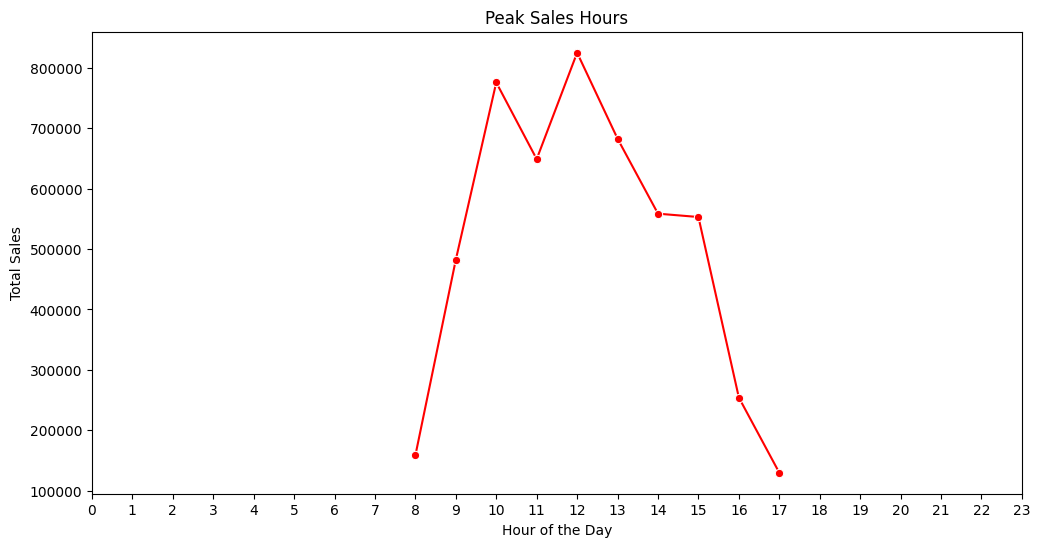

In [34]:
sales_by_hour = df.groupBy(hour(col("InvoiceDate")).alias("Hour")).agg(sum("Quantity").alias('TotalSales')).orderBy(col("TotalSales").desc()).limit(10)
# Convert to pandas Dataframe
sales_by_hour_pd = sales_by_hour.toPandas()

plt.figure(figsize=(12,6))
sns.lineplot(data=sales_by_hour_pd, x="Hour", y="TotalSales", marker="o", color="red")

# Labels & Title
plt.xlabel("Hour of the Day")
plt.ylabel("Total Sales")
plt.title("Peak Sales Hours")
plt.xticks(range(0, 24))  # Ensure all 24 hours are shown

plt.show()



Which countries contribute the most to sales?

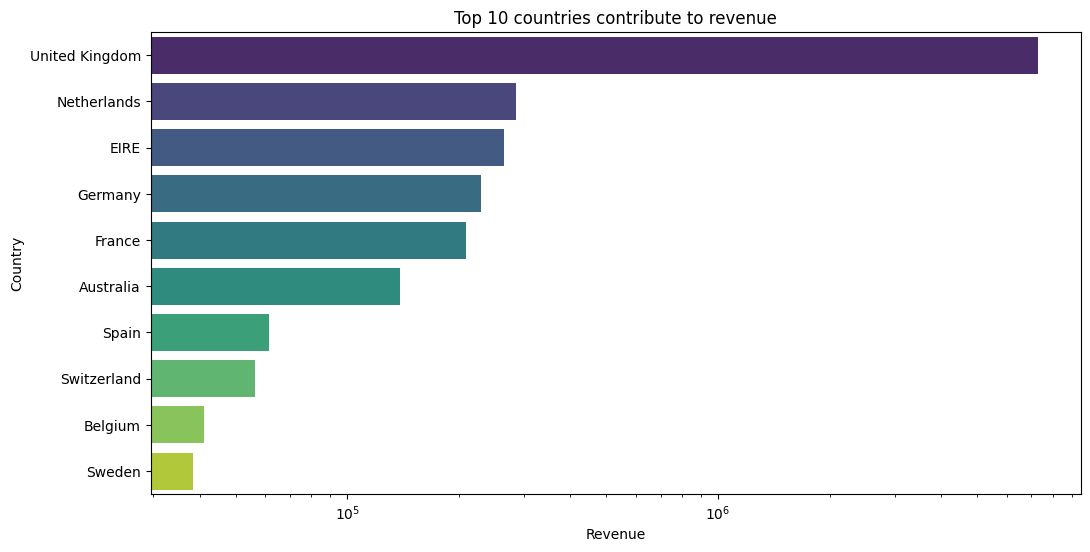

In [ ]:
top_countries = df.groupBy("Country").agg(sum(col("TotalAmount")).alias("Revenue"))
top_countries = top_countries.orderBy(col("Revenue").desc())
top_countries_pd = top_countries.toPandas()
top_countries_pd["Revenue"] = top_countries_pd["Revenue"].astype(float)

plt.figure(figsize=(12,6))
sns.barplot(data=top_countries_pd.head(10), y="Country", x="Revenue",  palette="viridis")
plt.xscale("log")
plt.xlabel("Revenue")
plt.ylabel("Country")
plt.title("Top 10 countries contribute to revenue")
plt.show()

Large contributed country is UK so the rest of the countries looks to tiny, so the most contributers exclude UK is :

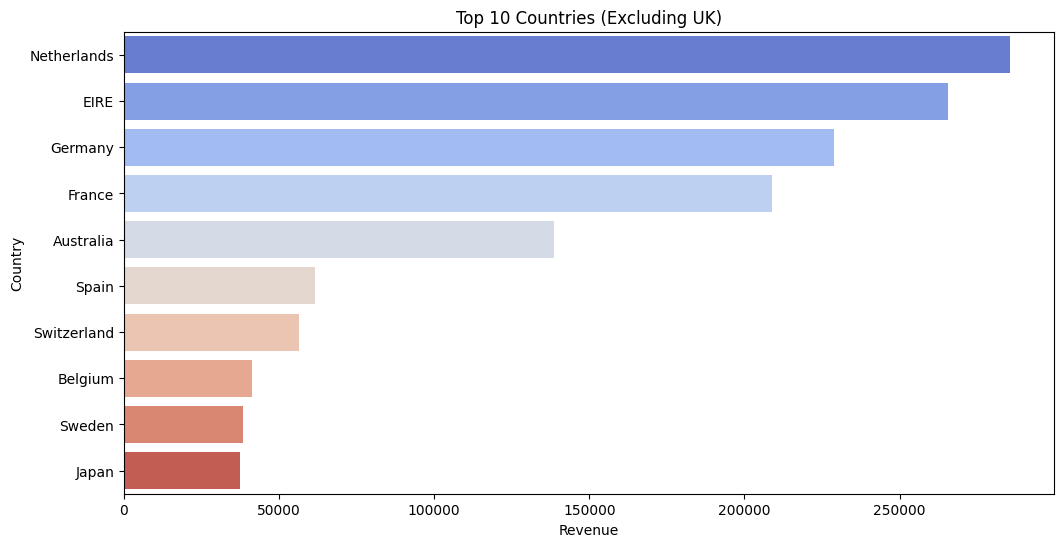

In [54]:
# Remove UK and replot
top_countries_no_uk = top_countries_pd[top_countries_pd["Country"] != "United Kingdom"]
plt.figure(figsize=(12,6))
sns.barplot(data=top_countries_no_uk.head(10), y="Country", x="Revenue", palette="coolwarm")
plt.xlabel("Revenue")
plt.ylabel("Country")
plt.title("Top 10 Countries (Excluding UK)")
plt.show()


# Conclusion : 
* High Value customers are the most valuable customers. they are more frequent and purchase in bulk.
* The most of the sales generate in September, ouctober, november and december month. And, the peask sale time in a day ia between 10pm to 1am.
* United Kingdom is the most revenue generator country and then Netherland, EIRE and Germany.
* "Paper Craft Little Birdie" and "Medium Ceramic Top Storage Jar" are the most sold products.

# Business Recommendations : 
* Target high-value customers with personalized offers.
* Optimize stock for top-selling products.
* ocus on high-revenue countries for better marketing strategies.
* Leverage peak sales hours for promotions.